<a href="https://colab.research.google.com/github/zozo123/AlgorithmVisualizer/blob/dev/Corner_Detector_march_10_2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from keras import models, layers
import numpy as np
from scipy import signal
from keras import backend as K

size=100

input_image = layers.Input(shape=(size, size, 1))

b2 = layers.Conv2D(128, (3,3),padding='same',  activation='relu')(input_image)
b2 = layers.MaxPooling2D((2,2))(b2)
b2 = layers.Conv2D(64, (3,3),padding='same',  activation='relu')(b2)
b2 = layers.MaxPooling2D((2,2))(b2)
# TOTEST: Add some intermidated dense layers
# b2 = layers.Dense(size)(b2)
b2 = layers.Conv2D(32, (2,2), activation='relu',  padding='same')(b2)
b2 = layers.MaxPooling2D((2,2))(b2)

b2 = layers.Conv2D(32, (2,2), activation='relu',  padding='same')(b2)
b2 = layers.MaxPooling2D((1,1))(b2)

b2 = layers.Flatten()(b2)
b2 = layers.Dense(25) (b2)
b2 = layers.Reshape((5,5,1))(b2)
b2 = layers.UpSampling2D((2,2))(b2)
b2 = layers.Conv2D(128, (2,2), activation='relu', padding='same')(b2)

b2 = layers.UpSampling2D((2,2))(b2)
b2 = layers.Conv2D(64, (2,2), activation='relu', padding='same')(b2)

b2 = layers.UpSampling2D((2,2))(b2)
b2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(b2)

# TOTEST: Try to use transposed convolution layers to up sample
b2 = layers.UpSampling2D((2,2))(b2)
b2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(b2)

# TOTEST: Try to avoid overshotting to higher dimensions 
b2 = layers.UpSampling2D((5,5))(b2)
b2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(b2)

b2 = layers.Conv2D(128, (2,2), activation='sigmoid',  padding='same')(b2)
b2_out = layers.MaxPooling2D((4,4))(b2)

output = layers.Conv2D(1, (1,1), activation='sigmoid', padding='same')(b2_out)

def custom_loss(y_true, y_predict):
  y_predict=K.clip(y_predict, K.epsilon(), 1 - K.epsilon())
  dom=K.tf.cast(K.tf.count_nonzero(-K.tf.multiply(y_true,K.log(y_predict))), K.tf.float32)
  return K.tf.reduce_sum(-K.tf.multiply(y_true,K.log(y_predict)))/dom + K.tf.reduce_mean(-K.tf.multiply((1-y_true),K.log((1-y_predict))))

def round_pred_nonzero(y_true, y_pred):
    return K.tf.count_nonzero(K.tf.round(y_pred))

def round_sigmoid_pred_nonzero(y_true, y_pred):
    return K.tf.count_nonzero(K.tf.round(K.sigmoid(y_pred)))
  
def true_nonzero(y_true, y_pred):
    return K.tf.count_nonzero(y_true)

def term_of_zero_cross(y_true, y_pred):
    return K.tf.count_nonzero(-K.tf.multiply(y_true,K.log(y_pred)))

def term_of_one_cross(y_true, y_pred):
    return K.tf.count_nonzero(-K.tf.multiply((1-y_true),K.log((1-y_pred))))

  
#output = layers.Dense(100, activation='sigmoid')(b2_out)
model = models.Model(input_image, output)
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy',round_pred_nonzero,round_sigmoid_pred_nonzero, true_nonzero, term_of_zero_cross, term_of_one_cross])

model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 128)     1280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 64)        73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 32)        8224      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 32)        0         
__________

In [0]:
%matplotlib inline
def generate_images(length):
  label:begin
  data   = np.zeros([length, size, size, 1])
  labels = np.zeros([length, size, size, 1])
  for j in range(length):
    m=np.eye(size)
    v=np.array([[1, 2, 3, 4, 3, 2, 1]])
            
    m=signal.convolve2d(m, v*v.T , 'same')
    l=np.zeros([size,size])
    for i in range(0,size,6):
      if np.random.rand(1)[0] < 0.5 and i > 6 and i < 94:
        dim = np.int(2*np.round(3*(1+np.random.rand(1)[0])))
        k = 250.0*np.ones([dim,dim])
        half_win=np.int(dim/2)
        m[i-half_win:i+half_win, i-half_win:i+half_win] = k
        corner=200*(0.5+np.random.rand(1)[0])
        m[i-half_win,i+half_win-1] += corner
        m[i+half_win-1,i-half_win] += corner
        l[i-half_win,i+half_win] = 1
        l[i+half_win,i-half_win] = 1
    j=0
    while True:
      j=(j+1)%length
      data[j,:,:,0]    = m
      labels[j,:,:,0]  = l      
      yield (data, labels)
      
%matplotlib inline
def generate_images_other(length):
  data   = np.zeros([length, size, size, 1])
  labels = np.zeros([length, size, size, 1])
  
  while True:
    for j in range(length):
      m=np.eye(size)
      v=np.array([[1, 2, 3, 4, 3, 2, 1]])
            
      m=signal.convolve2d(m, v*v.T , 'same')
      l=np.zeros([size,size])
      for i in range(0,size,6):
        if np.random.rand(1)[0] < 0.5 and i > 6 and i < 94:
          dim = np.int(2*np.round(3*(1+np.random.rand(1)[0])))
          k = 250.0*np.ones([dim,dim])
          half_win=np.int(dim/2)
          m[i-half_win:i+half_win, i-half_win:i+half_win] = k
          corner=200*(0.5+np.random.rand(1)[0])
          m[i-half_win,i+half_win-1] += corner
          m[i+half_win-1,i-half_win] += corner
          l[i-half_win,i+half_win] = 1
          l[i+half_win,i-half_win] = 1

      data[j,:,:,0]    = m
      labels[j,:,:,0]  = l
      yield (data, labels)

In [0]:
# using other
model.fit_generator(generate_images_other(16), steps_per_epoch=100, epochs=10, use_multiprocessing=True)

Epoch 1/10
100/100 [==============================] - 102s 1s/step - loss: 0.5437 - acc: 0.8486 - round_pred_nonzero: 24422.7700 - round_sigmoid_pred_nonzero: 160000.0000 - true_nonzero: 204.8200 - term_of_zero_cross: 204.8200 - term_of_one_cross: 159795.1800
Epoch 2/10
100/100 [==============================] - 96s 960ms/step - loss: 0.1721 - acc: 0.9586 - round_pred_nonzero: 6839.6000 - round_sigmoid_pred_nonzero: 160000.0000 - true_nonzero: 220.7200 - term_of_zero_cross: 220.7200 - term_of_one_cross: 159779.2800
Epoch 3/10
100/100 [==============================] - 96s 960ms/step - loss: 0.1639 - acc: 0.9625 - round_pred_nonzero: 6220.1700 - round_sigmoid_pred_nonzero: 160000.0000 - true_nonzero: 219.0400 - term_of_zero_cross: 219.0400 - term_of_one_cross: 159780.9600
Epoch 4/10
100/100 [==============================] - 96s 958ms/step - loss: 0.0934 - acc: 0.9805 - round_pred_nonzero: 3349.2800 - round_sigmoid_pred_nonzero: 160000.0000 - true_nonzero: 225.1000 - term_of_zero_cross:

10 10000
(1, 100, 100, 1)
10 46
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


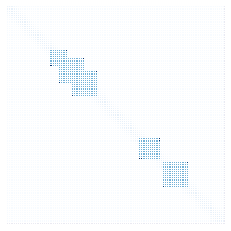

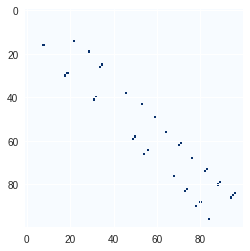

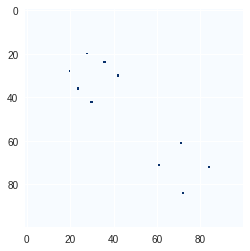

In [0]:
from matplotlib import pyplot as plt
from scipy.special import expit as sigmoid
for image, labels  in generate_images(1):
  predicted = model.predict(image)
  print(np.count_nonzero(labels), np.count_nonzero(predicted))
  print(image.shape)
  plt.figure()
  plt.imshow(image[0,:,:,0], cmap='Blues',aspect='equal')
  ax = plt.gca();
  ax.set_xticks(np.arange(0, 101, 1));
  ax.set_yticks(np.arange(0, 101, 1));
  ax.set_xticklabels([]);
  ax.set_yticklabels([]); 
  ax.grid(which='major', color='w', linestyle='-', linewidth=1)

  plt.figure()
  plt.imshow(predicted[0,:,:,0]>0.991, cmap='Blues')
  plt.figure()
  plt.imshow(labels[0,:,:,0]==1, cmap='Blues')
  print(np.count_nonzero(labels[0,:,:,0]),np.count_nonzero(predicted[0,:,:,0]>0.99))
  print(np.round(predicted[0,:,:,0]))
  plt.figure()
  plt.hist(predicted[0,:,:,0].flatten(), normed=True, bins=30)
  plt.ylabel('Probability');
  break


In [0]:
!pip3 install pydotplus
!pip3 install pydot
!apt-get -qq install -y graphviz && pip3 install -q pydot
!pip3 install pydot-ng
!pip3 install graphviz
!apt-get install python-pydot python-pydot-ng graphviz 

import pydot

from keras.utils import plot_model
plot_model(model)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
python-pydot is already the newest version (1.2.3-1).
python-pydot-ng is already the newest version (1.0.0-3).
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.


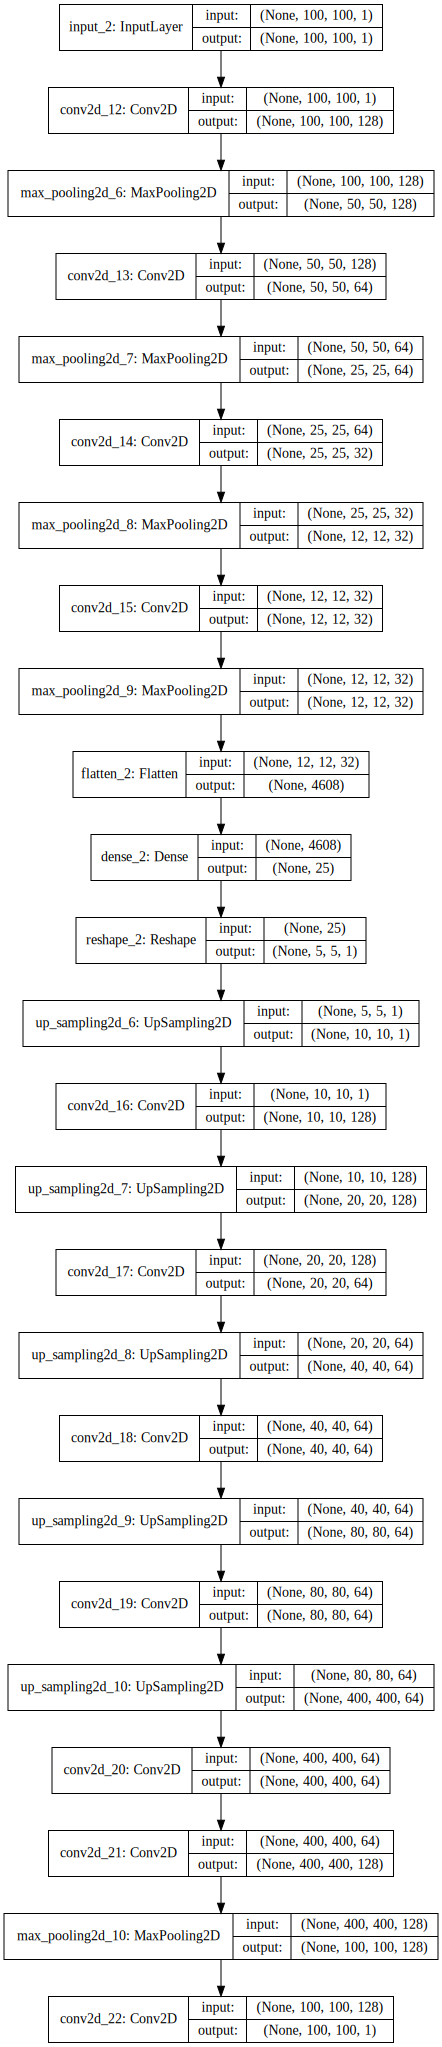

In [0]:

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [0]:
!pip3 install pydotplus
!pip3 install pydot
!apt-get -qq install -y graphviz && pip3 install -q pydot
!pip3 install pydot-ng
!pip3 install graphviz
!apt-get install python-pydot python-pydot-ng graphviz 
import pydot

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
python-pydot is already the newest version (1.2.3-1).
python-pydot-ng is already the newest version (1.0.0-3).
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.


In [0]:
model